All needed librarys

In [53]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.nddata import Cutout2D
from astropy import units
from astropy.io import fits
from astropy.modeling.models import Gaussian2D
import glob
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from clustar.core import ClustarData

Define Size of image in pixels and object in image
The object is a standard object from astropy, the idea is to use one of our own gaussian.

In [54]:
y, x = np.mgrid[0:500, 0:500]
data = Gaussian2D(1, 250, 250, 10, 5, theta=3)(x, y)

Here we plot the actual image

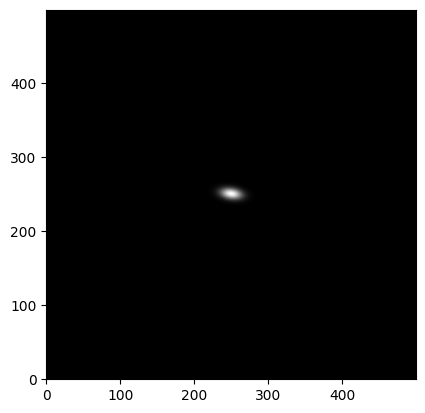

In [55]:
plt.imshow(data, origin='lower', cmap='gray')
plt.show()

Lets say we want to crop the image to a standard size 

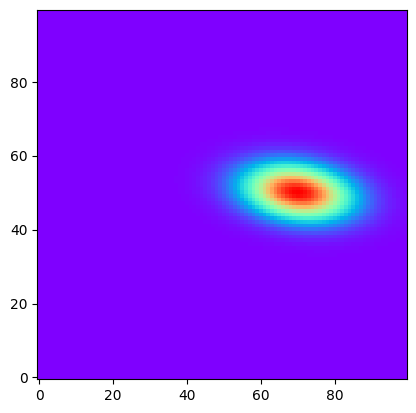

In [56]:
crop_center = (230, 250)
crop_size = units.Quantity((100, 100), units.pixel)
crop = Cutout2D(data, crop_center, crop_size)

plt.imshow(crop.data, origin='lower', cmap='rainbow')
plt.show()

Load a FITS file instead of simulating

In [57]:
#Get all the fits files adresses un a dictionary
filenames = glob.glob('data/*.fits')
data_set = {}

Find object of interest in FITS-file and return pos 

In [58]:
def find_object_pos(file):

    cd = ClustarData(path=file, group_factor=.4)
    if len(cd.groups) > 0:
        disk = cd.groups[0]
        bounds = disk.image.bounds
        x = (bounds[2] + bounds[3])/2 
        y = (bounds[0] + bounds[1])/2
        return (x, y)
    else:
        print("No object found in {}".format(file))
        return None


Go through all the FITS adresses and print the graphs

No object found in data\hh212_2015_band7_0.fits
No object found in data\hh212_2015_band7_1.fits
No object found in data\hh212_2016_band7_1.fits


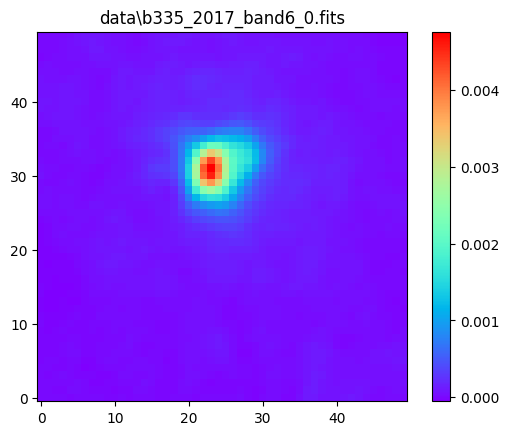

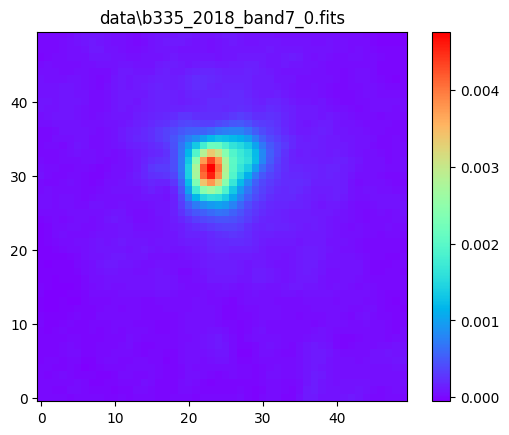

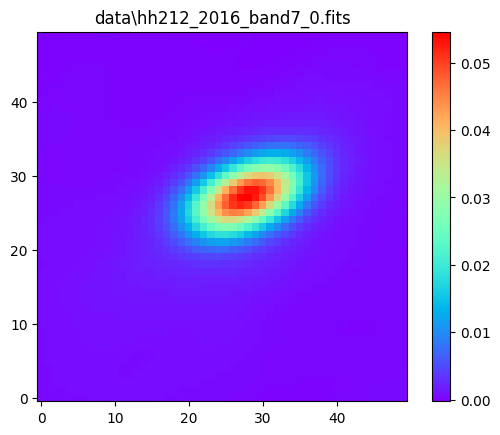

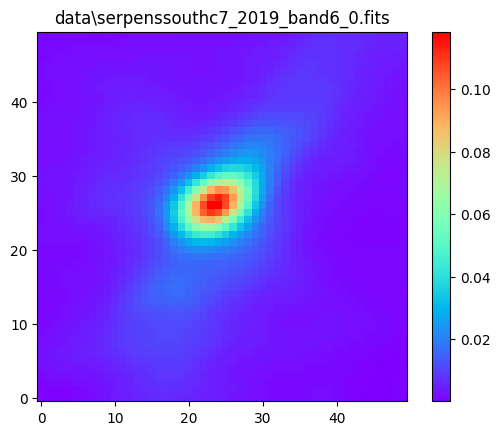

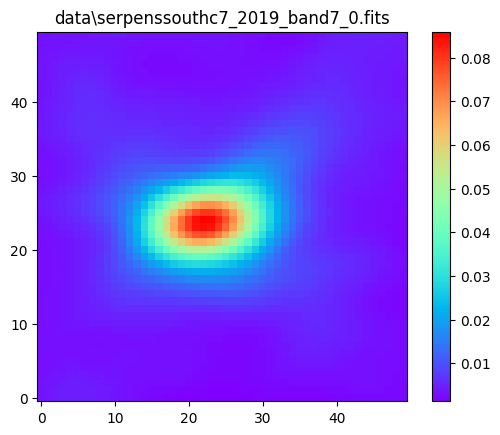

In [63]:
gaussians = []
for file in filenames:
    img_header = fits.open(file)
    img_data = fits.getdata(file)
    object_pos = find_object_pos(file)

    if object_pos != None:

        #Data shape is (1, 1, x, y) we want it to be (x, y)
        img_data.shape = (img_data.shape[2], img_data.shape[3])

        # Set the size of the crop in pixels
        im_size = 80
        crop_size = units.Quantity((im_size, im_size), units.pixel)

        img_crop = Cutout2D(img_data, object_pos, crop_size)

        gaussians.append(img_crop)

        plt.figure()
        plt.imshow(img_crop.data, origin='lower', cmap='rainbow')
        plt.colorbar()
        plt.title(file)


Rotate Data

Rotate the crop by the given angle and return the rotated crop moved with ranom ofset

In [80]:
import random
from scipy.ndimage import rotate


def crop_rotated_disk(disk_to_rotate, angle):
    # Rotate the disk
    rotated_disk = rotate(disk_to_rotate, angle)
    # Since rotating pads the image, we need to crop it to the original size
    (x, y) = (len(rotated_disk[0]), len(rotated_disk))
    print(x, y)

    shift_interval = 4
    rand_x_shift = random.randint(-shift_interval, shift_interval)
    rand_y_shift = random.randint(-shift_interval, shift_interval)

    (x_lower, x_upper) = int((x/2 - im_size/2)) + rand_x_shift , int(x/2 + im_size/2) + rand_x_shift
    (y_lower, y_upper) = int((y/2 - im_size/2)) + rand_y_shift , int(y/2 + im_size/2) + rand_y_shift

    return rotated_disk[x_lower:x_upper, y_lower:y_upper]


Flip and mirror gaussian

In [60]:
def flip_disk(disk_to_flip):

    flipped_disk = disk_to_flip

    if bool(random.getrandbits(1)):
        flipped_disk = np.fliplr(flipped_disk)

    if bool(random.getrandbits(1)):
        flipped_disk = np.flipud(flipped_disk)

    if bool(random.getrandbits(1)):
        flipped_disk = np.flip(flipped_disk)
        
    return flipped_disk

Print and augment data

Got through all the found objects and augment them

58 58
66 66
61 61
66 66
61 61
53 53
67 67
53 53
62 62
61 61
51 51
61 61
65 65
62 62
71 71
69 69
60 60
56 56
70 70
66 66


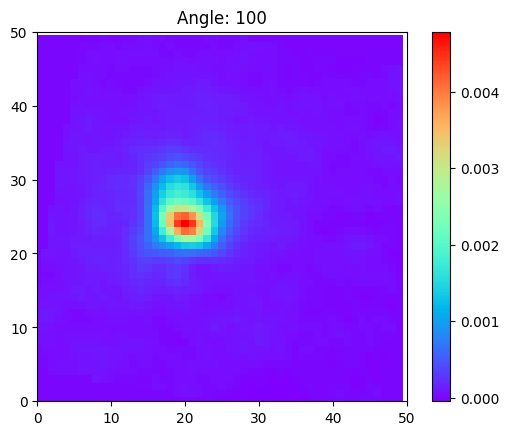

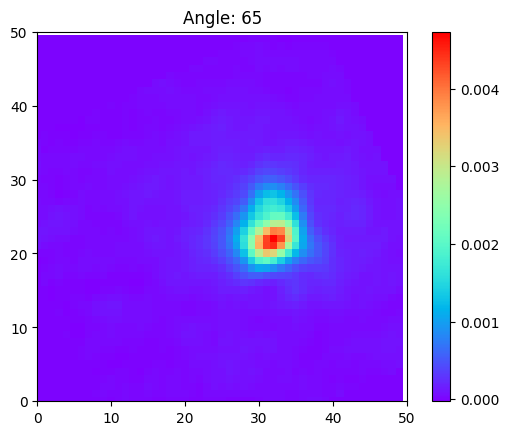

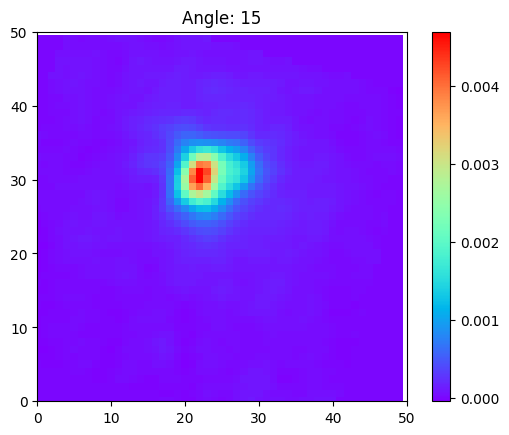

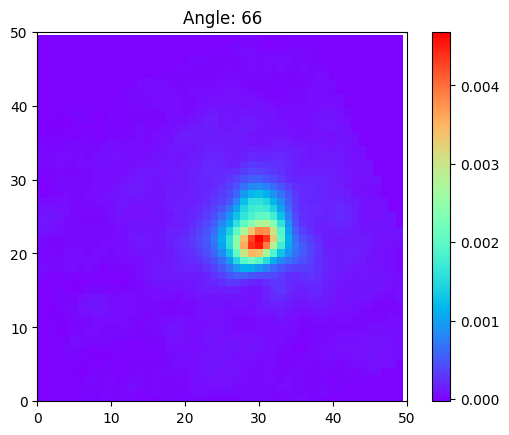

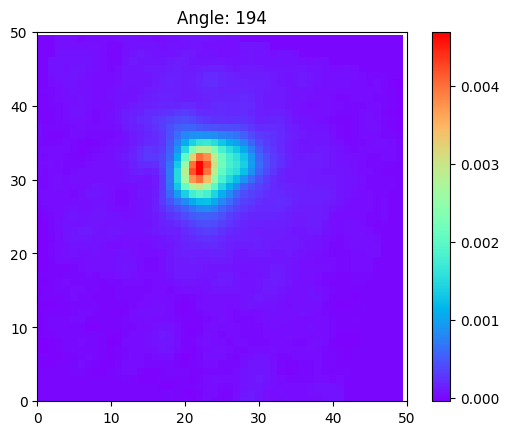

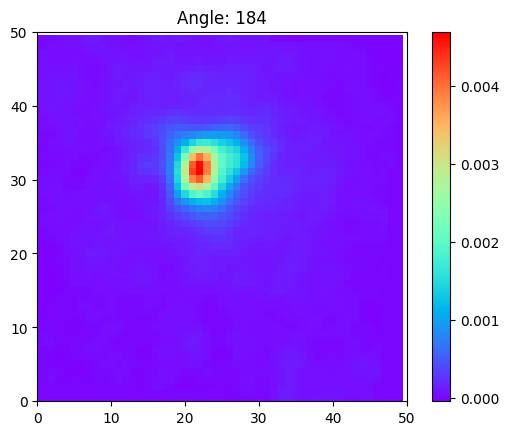

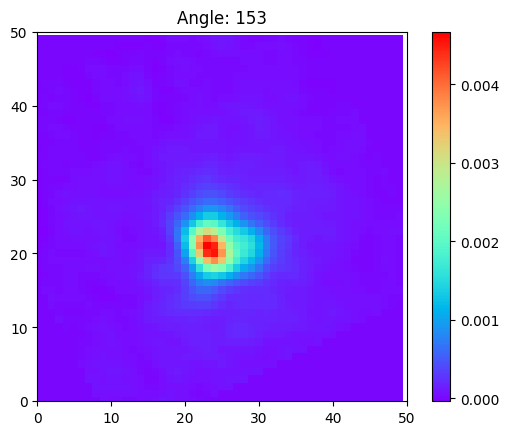

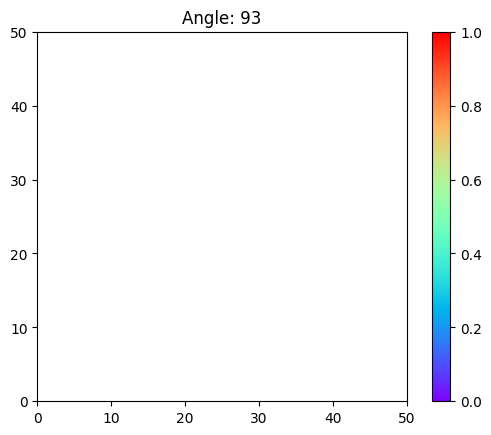

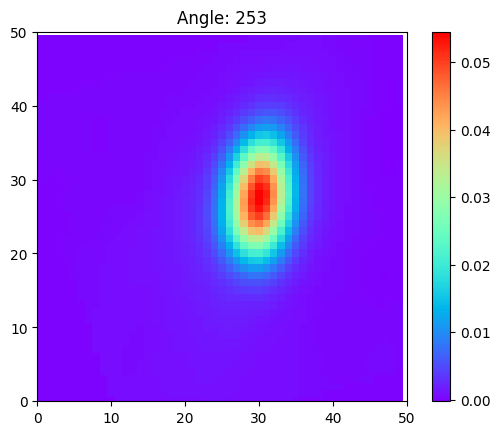

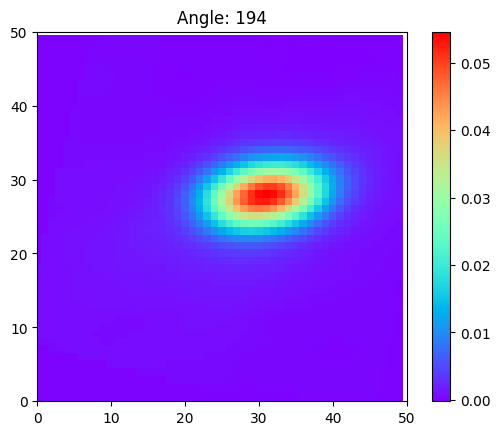

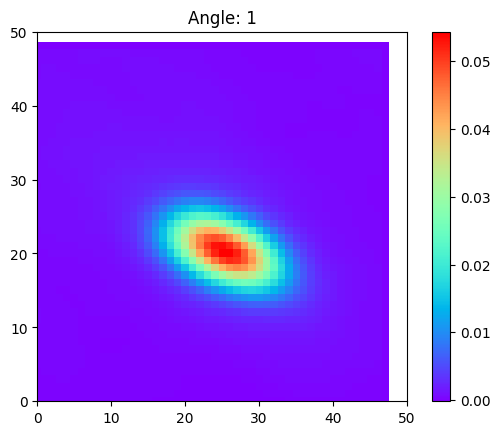

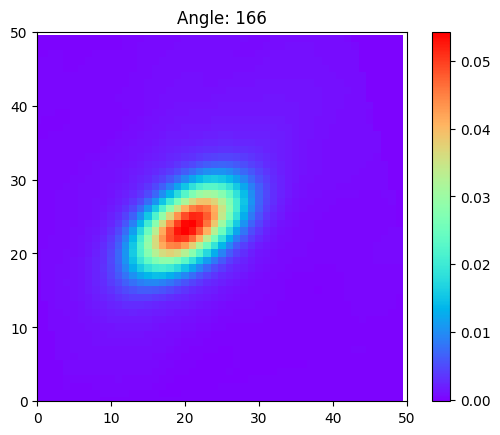

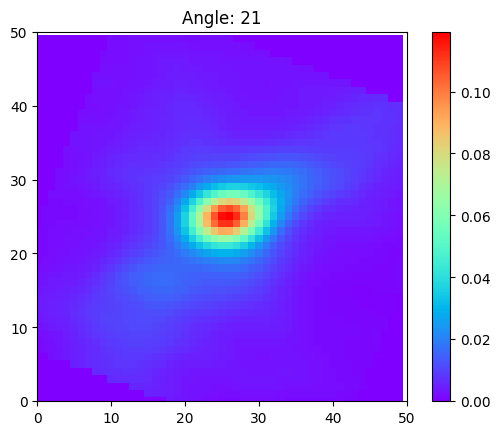

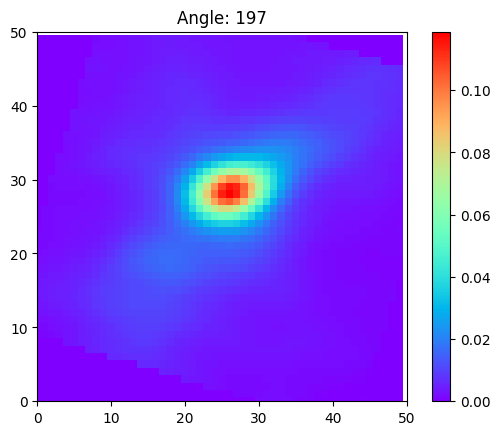

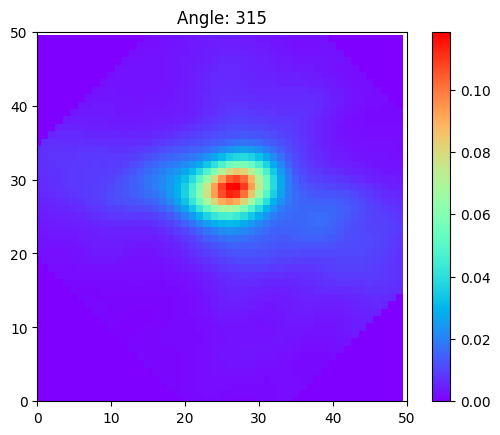

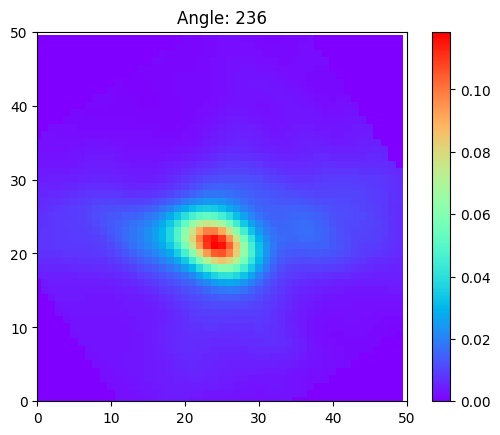

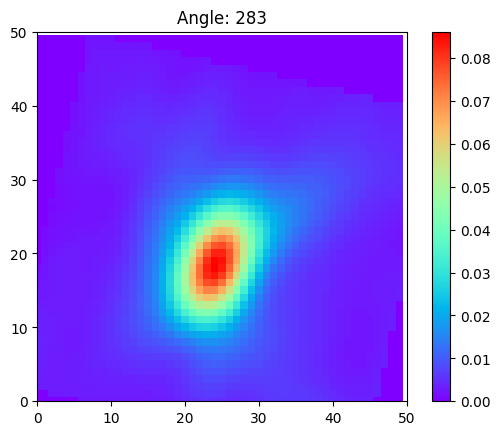

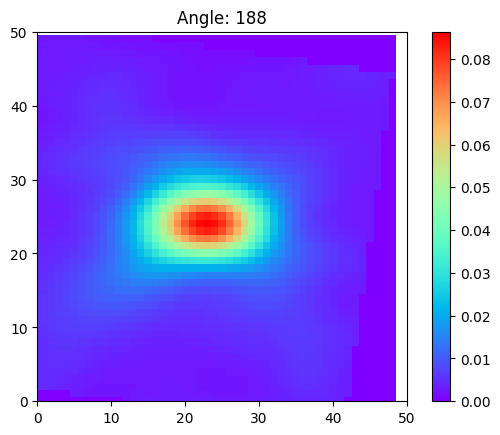

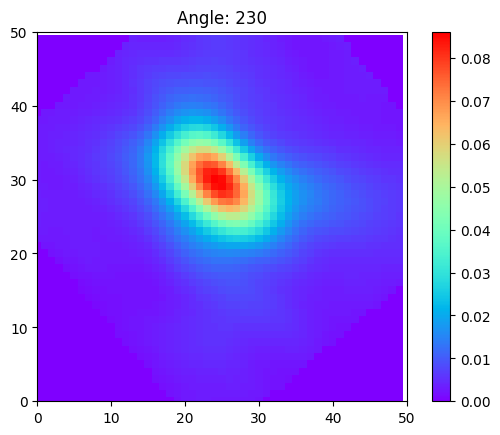

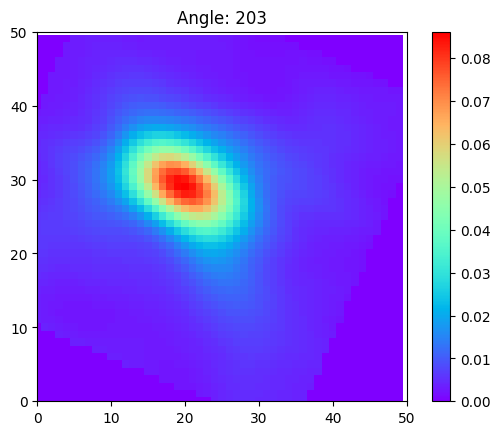

In [81]:

augmentations_per_gaussian = 4

for gaussian in gaussians:
    for i in range(0, augmentations_per_gaussian):

        gaussian_disk = flip_disk(gaussian.data)

        angle = random.randint(0, 360) 
        gaussian_disk = crop_rotated_disk(gaussian_disk, angle)
        
        plt.figure()
        plt.xlim(0, im_size)
        plt.ylim(0, im_size)
        plt.imshow(gaussian_disk, origin='lower', cmap='rainbow')
        plt.colorbar()
        plt.title("Angle: {}".format(angle))